# Generic DataLoader and Data Visualization for Clasification

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset, SecuencialSamplesDataset, TripletsDataset, AnomalyDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset=FactoryDataset.mnist

print(pathname)
print(name_dataset)

/home/pdmf/.datasets
mnist


# Visualization Dataset

In [3]:
def visualizatedataset( data, num=25, imsize=(64,64,3), padding=1 ):    
    """
    Visualization data set
        @data: data loader 
        @num: number of images show
    """
    
    databatch = torch.zeros( [num, imsize[2], imsize[0], imsize[1]], dtype=torch.float32 )
    for i in range(num): 
        idx = i # np.random.randint( len(data) )
        databatch[i,...] = data[idx]['image']        
    grid = utils.make_grid( databatch , nrow= int(np.sqrt(num)), normalize=True, padding=padding )       
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    

## Load dataset

In [13]:
dataloader = Dataset(
    data=FactoryDataset.factory(pathname=pathname, name=name_dataset, subset=FactoryDataset.training, download=True ),
    num_channels=3,
    transform=transforms.Compose([
        mtrans.ToResize( (64, 64), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ),
        mtrans.ToTensor(),
        mtrans.ToNormalization(),
        ])
    )

print(len( dataloader.data.classes ))
print( dataloader.data.class_to_idx )
# print( dataloader.data.classes )
# print(len(dataloader))
# print( dataloader.data.samples )



Files already downloaded and verified
10
{'bird': 2, 'deer': 4, 'cat': 3, 'frog': 6, 'ship': 8, 'truck': 9, 'automobile': 1, 'horse': 7, 'dog': 5, 'airplane': 0}


## Visualization dataset 

### Visualized examplos for classes 

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
101


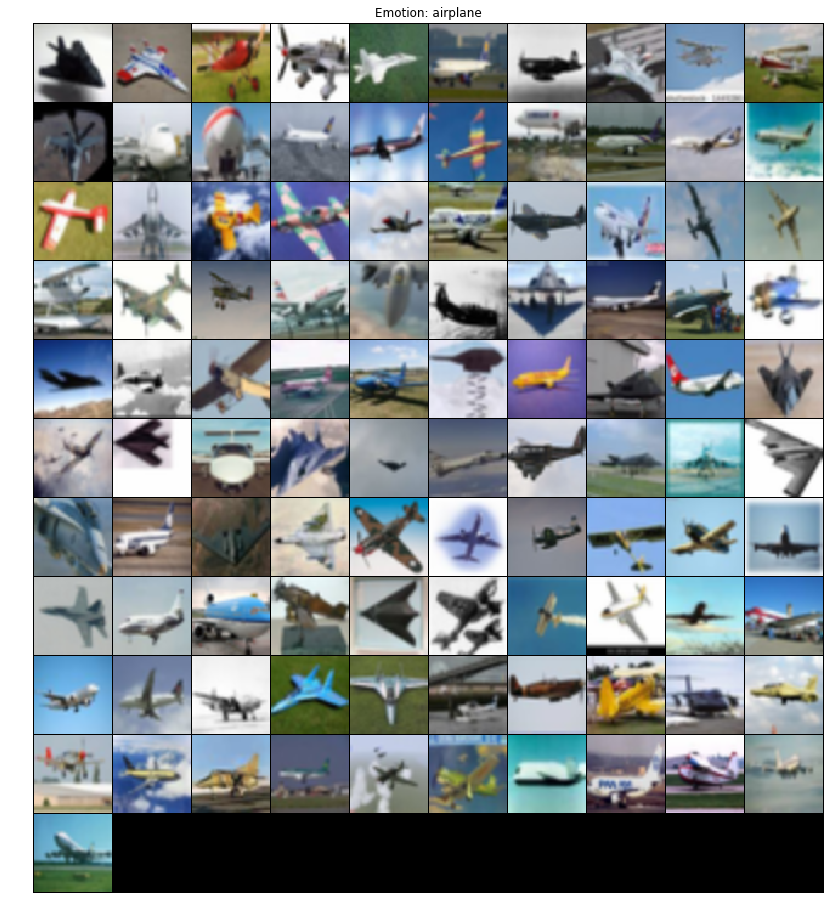

In [14]:

num=100
classes_select = 0
dataloader_select = []
k=0
labels = dataloader.labels
for i in range( len(dataloader) ):
    if labels[i] != classes_select: 
        continue        
    dataloader_select.append(dataloader[i]); k+=1
    if k > num: break;

n = len(dataloader_select)

print(dataloader.data.classes)
print(n)

plt.figure( figsize=(16,16))
visualizatedataset(dataloader_select, num=n, imsize=(64,64,3) )
plt.title('Emotion: {}'.format( dataloader.data.classes[ classes_select ] ) )
plt.axis('off')
plt.ioff()
plt.show() 

#Afew ['Neutral',      'Happy',      'Surprise',      'Sad',          'Angry',      'Disgust',       'Fear']
#Ck   ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
#JAF  ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
#Bu   ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
#FER  ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']


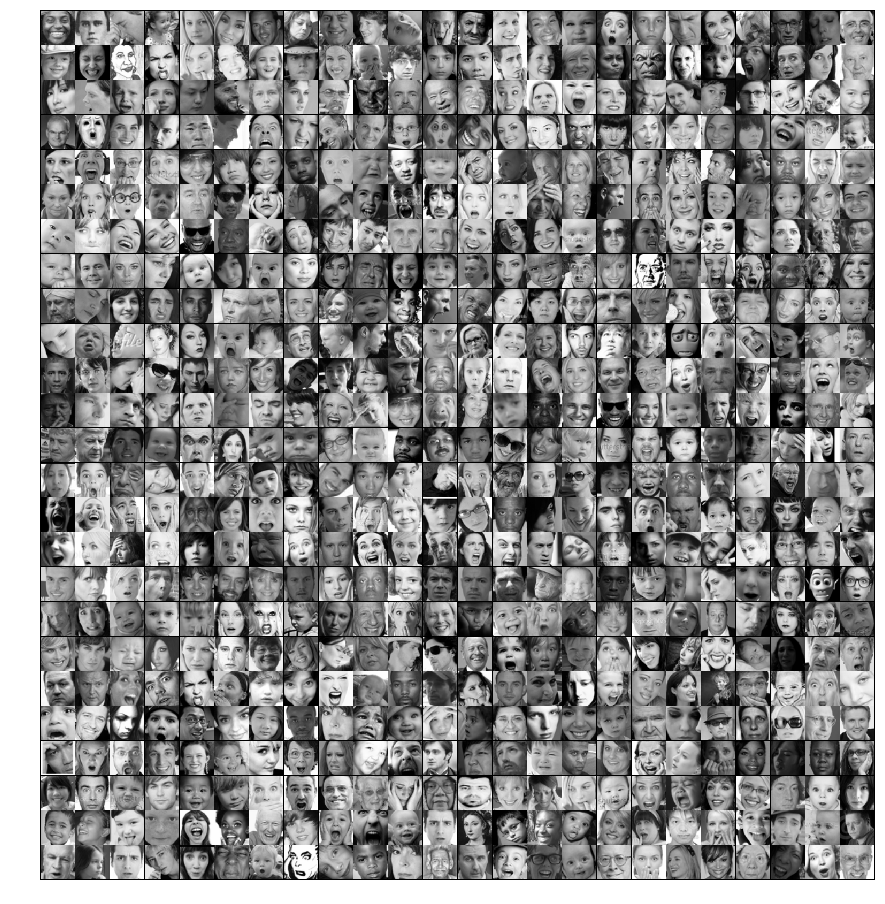

In [9]:

# print(dataloader.labels)
# print(dataloader.classes)
# print(dataloader.data.classes)
# print(dataloader.data.class_to_idx)

plt.figure( figsize=(16,16))
view.visualizatedataset(dataloader, num=600, imsize=(64,64,3) )
plt.axis('off')
plt.ioff()
plt.show() 


In [26]:
# save image 
view.savedataset('../out/{}.png'.format(name_dataset), dataloader, num=1000, imsize=(64,64,3) )
print('save ...')

save ...


# Data Aumentation

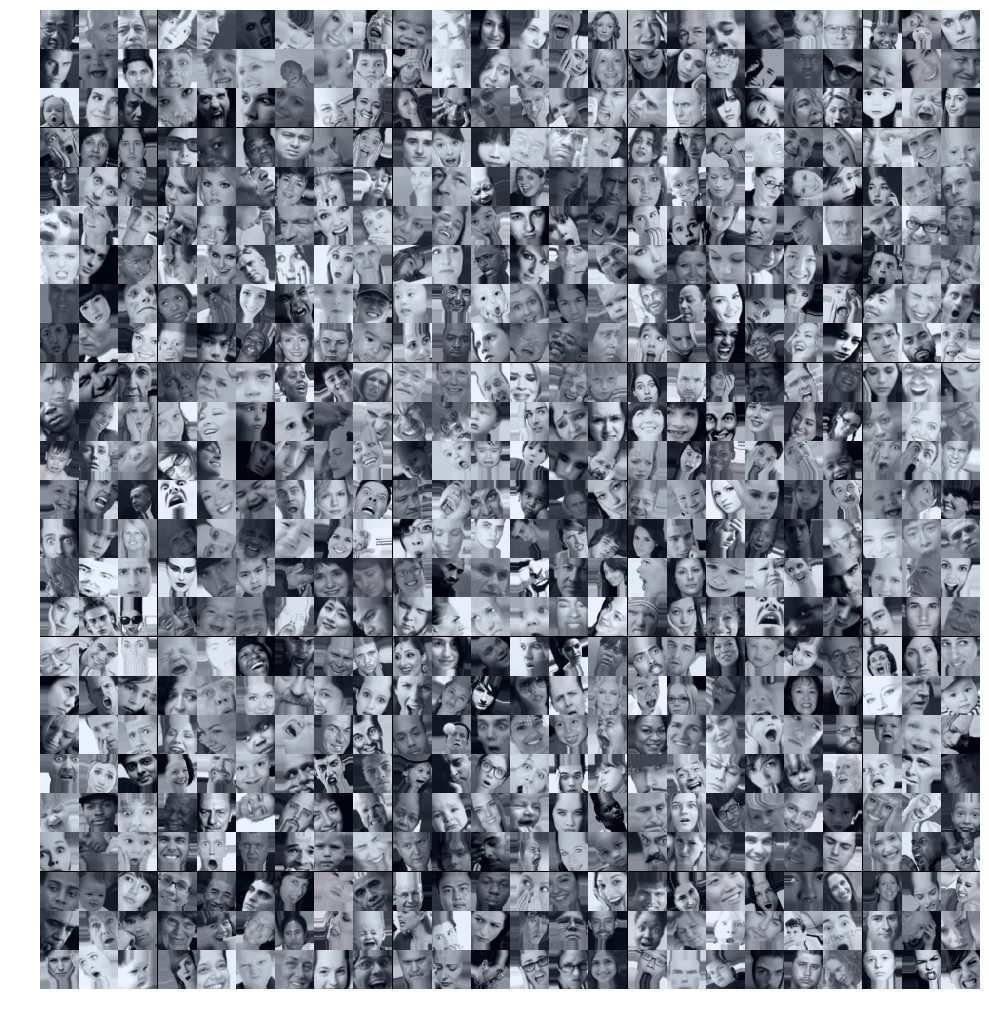

In [7]:

size_input = 244

# transformations 
normalize = mtrans.ToMeanNormalization(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

transforms_aug = transforms.Compose([
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE ) ,
    #mtrans.ToResize( (size_input+20, size_input+20), resize_mode='asp' ) ,
    #mtrans.RandomCrop( (size_input, size_input), limit=10, padding_mode=cv2.BORDER_REFLECT_101  ) , 
    mtrans.RandomScale(factor=0.25, padding_mode=cv2.BORDER_REPLICATE ), 
    mtrans.RandomGeometricalTransform( angle=30, translation=0.2, warp=0.02, padding_mode=cv2.BORDER_REPLICATE ),
    mtrans.ToRandomTransform( mtrans.HFlip(), prob=0.5 ),
    #------------------------------------------------------------------
    
    #mtrans.RandomRGBPermutation(),
    mtrans.ToRandomChoiceTransform( [
        mtrans.RandomBrightness( factor=0.15 ), 
        mtrans.RandomContrast( factor=0.15 ),
        #mtrans.RandomSaturation( factor=0.15 ),
        mtrans.RandomHueSaturation( hue_shift_limit=(-5, 5), sat_shift_limit=(-11, 11), val_shift_limit=(-11, 11) ),
        mtrans.RandomGamma( factor=0.30  ),        
        mtrans.ToRandomTransform(mtrans.ToGrayscale(), prob=0.15 ),
        ]),    
    mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.0001), prob=9.0 ),    
    
    #------------------------------------------------------------------
    mtrans.ToTensor(),
    normalize,
    ]) 


transforms_det = transforms.Compose([
    #mtrans.ToResize( (size_input, size_input), resize_mode='crop' ) ,
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ) ,
    mtrans.ToTensor(),
    normalize,
    ])

dataloader = Dataset(
    data=FactoryDataset.factory(pathname=pathname, name=name_dataset, subset=FactoryDataset.training, download=False ),
    num_channels=3,
    transform=transforms_aug
    )


plt.figure( figsize=(18,18))
view.visualizatedataset(dataloader, num=600, imsize=(size_input,size_input,3), padding=1 )
plt.axis('off')
plt.ioff()
plt.show() 


# Explore Dataset

[0 1 2 3 4 5 6 7 8 9]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


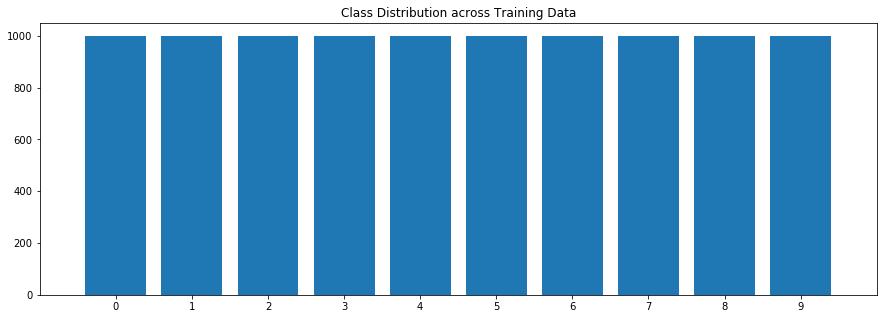

In [15]:

data = FactoryDataset.factory(pathname=pathname, name=name_dataset, subset=FactoryDataset.validation, download=False )
labels = data.labels

# Count frequency of each label
label_class_batched = labels
labels, counts = np.unique(label_class_batched, return_counts=True)

print(labels)
print(counts)
print(np.sum(counts))


# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,10])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Training Data')
plt.show()


# Data Loader Baseline

0 torch.Size([64, 3, 64, 64]) torch.Size([64, 10])
tensor(0.) tensor(1.) torch.Size([64, 64])
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 


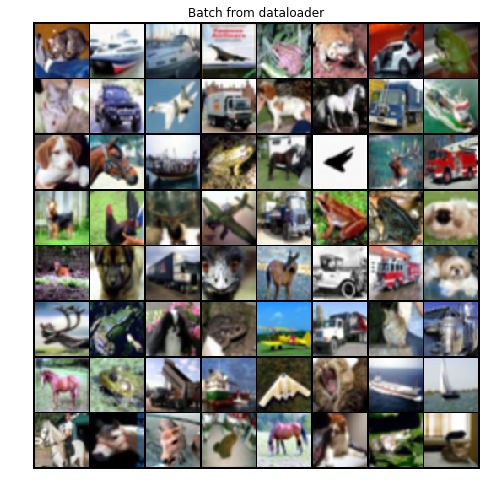

In [16]:
size_input=64

# transformations 
normalize = mtrans.ToMeanNormalization(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

transforms_data = transforms.Compose([
    #mtrans.ToResize( (size_input, size_input), resize_mode='crop' ) ,
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE ) ,
    mtrans.ToTensor(),
    mtrans.ToWhiteNormalization(),
    ])

data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.validation, 
        download=False ),
    num_channels=3,
    transform= transforms_data,
    )
    
dataloader = DataLoader(data, batch_size=64, shuffle=False, num_workers=1 )

label_batched = []
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())
    
    image = sample_batched['image'][0,0,...]
    print(torch.min(image), torch.max(image), image.shape )

    # observe 4th batch and stop.
    if i_batch == 0: 
        #plt.figure()
        view.show_limage_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()        
        label_batched = sample_batched['label'].numpy()        
        break
    

